# CE ARR

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Data Pre-processing

In [2]:
df_train = pd.read_csv('../train_data.nosync/train_data.csv', header=None)
df_val = pd.read_csv('./val_data.csv', header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,-0.265,-0.265,-0.290,-0.310,-0.325,-0.315,-0.295,-0.280,-0.285,-0.280,...,-0.170,-0.145,-0.155,-0.170,-0.180,-0.185,-0.190,-0.19,-0.200,0.0
1,-0.110,-0.110,-0.105,-0.095,-0.080,-0.050,-0.050,-0.050,-0.050,-0.040,...,-0.315,-0.285,-0.275,-0.265,-0.260,-0.275,-0.290,-0.28,-0.275,12.0
2,-0.380,-0.380,-0.400,-0.415,-0.395,-0.380,-0.380,-0.395,-0.390,-0.415,...,-0.390,-0.410,-0.445,-0.435,-0.420,-0.415,-0.400,-0.41,-0.425,0.0
3,-0.955,-0.945,-0.960,-0.960,-0.970,-0.970,-0.955,-0.935,-0.940,-0.920,...,-0.995,-1.000,-1.010,-1.040,-1.040,-1.025,-1.020,-1.00,-0.990,0.0
4,0.030,0.030,0.055,0.060,0.040,0.030,0.035,0.040,0.060,0.050,...,-0.010,0.000,-0.005,-0.025,-0.015,-0.020,-0.015,0.01,0.005,0.0


In [3]:
df_train.shape

(65670, 251)

In [4]:
# Split the training data into feature and target
X_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:,-1:].values.ravel()
X_val = df_val.iloc[:,:-1].values
y_val = df_val.iloc[:,-1:].values.ravel()

## Fourier Attempt

In [5]:
time = np.arange(0, 250)
fx_train = df_train.iloc[:,:-1].values
fy_train = df_train.iloc[:,-1:].values.ravel()
fx_val = df_val.iloc[:,:-1].values
fy_val = df_val.iloc[:,-1:].values.ravel()

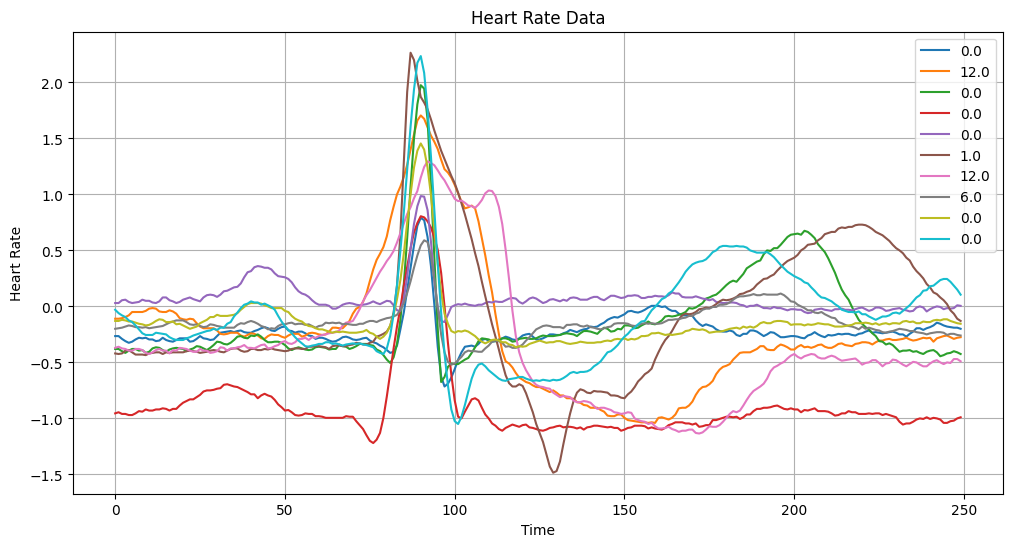

In [6]:
plt.figure(figsize=(12, 6))

cnt = 10
for beat in fx_train[:cnt]:
    plt.plot(beat)

plt.legend(y_train[:cnt])
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Data')
plt.grid()
plt.show()

In [7]:
# Parameter to determine frequency breadth of the FFT data as percentage of spectrum
total_breadth = len(fx_train[0])
perc =.3

breadth = (perc*total_breadth)
breadth = int(breadth)
breadth

75

In [8]:
# Calculate FFT's for the Train Set
# Number (count) of beats to apply transform too and arrays for data
cnt = len(fx_train)
fx_train_mags = []
fx_train_magsdb = []
fx_train_freqs = []


for beat in fx_train[:cnt]:
    # Calculate the FFT
    fft_result = np.fft.fft(beat)

    # Calculate freq values corresponding with the FFT result
    freq = np.fft.fftfreq(len(time))

    # Eliminate negative frequencies
    pos_freqs = freq > 0
    fft_result = fft_result[pos_freqs]
    freq = freq[pos_freqs]

    # Calculate magnitude of the FFT result
    mag = np.abs(fft_result)
    mag_db = 20 * np.log10(mag)

    fx_train_mags.append(mag[0:breadth])
    fx_train_magsdb.append(mag_db[0:breadth])
    fx_train_freqs.append(freq[0:breadth])

In [9]:
# Calculate FFT's for the Validation Set
cnt = len(fx_val)
fx_val_mags = []
fx_val_magsdb = []
fx_val_freqs = []

for beat in fx_val[:cnt]:
    # Calculate the FFT
    fft_result = np.fft.fft(beat)

    # Calculate freq values corresponding with the FFT result
    freq = np.fft.fftfreq(len(time))

    # Eliminate negative frequencies
    pos_freqs = freq > 0
    fft_result = fft_result[pos_freqs]
    freq = freq[pos_freqs]

    # Calculate magnitude of the FFT result
    mag = np.abs(fft_result)
    mag_db = 20 * np.log10(mag)

    fx_val_mags.append(mag[0:breadth])
    fx_val_magsdb.append(mag_db[0:breadth])
    fx_val_freqs.append(freq[0:breadth])

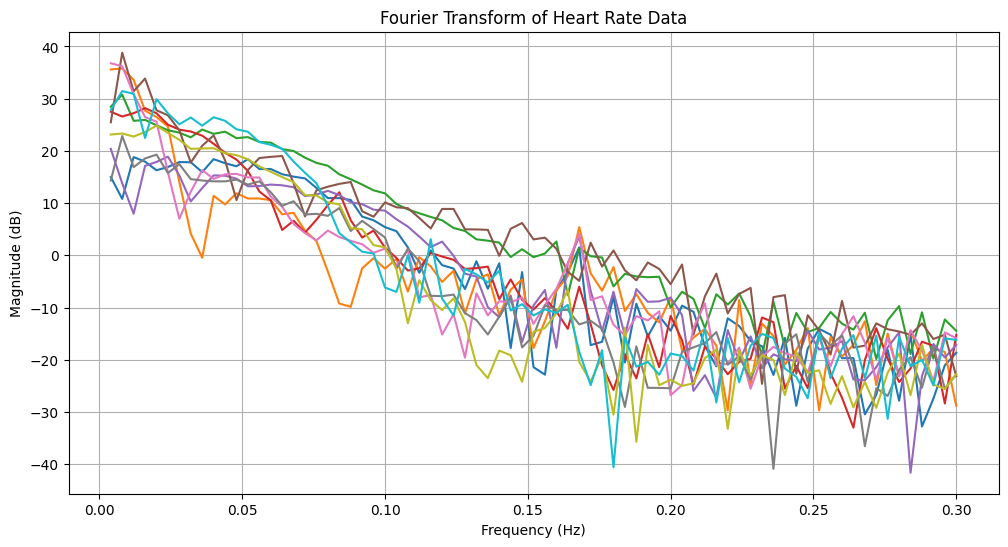

In [10]:
# Determine amount and plot some FFT training data samples
plt_cnt = 10
plt.figure(figsize=(12, 6))

for beat in fx_train_magsdb[:plt_cnt]:
    plt.plot(fx_train_freqs[0], beat)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Heart Rate Data')
plt.grid()
plt.show()

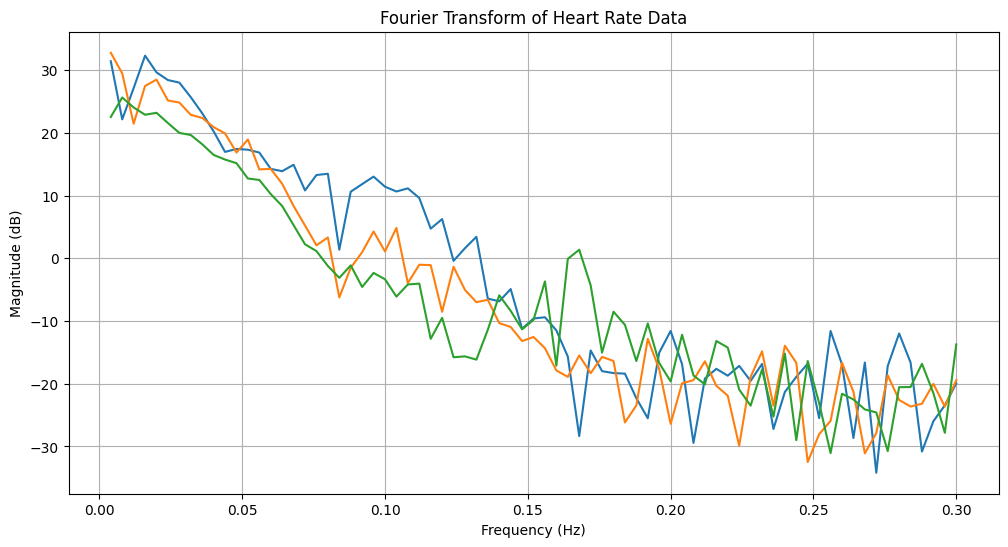

In [11]:
# Determine amount and plot some FFT validation data samples
plt_cnt = 3
plt.figure(figsize=(12, 6))

for beat in fx_val_magsdb[:plt_cnt]:
    plt.plot(fx_val_freqs[0], beat)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Heart Rate Data')
plt.grid()
plt.show()

[0.35864236 0.50545503 0.56582242 0.60401587 0.63272411 0.64798101
 0.66140118 0.67197642 0.68201446 0.69181304 0.70107726 0.70988831
 0.71848733 0.72659351 0.73467642 0.74240815 0.74981354 0.75709299
 0.76427574 0.7713138 ]


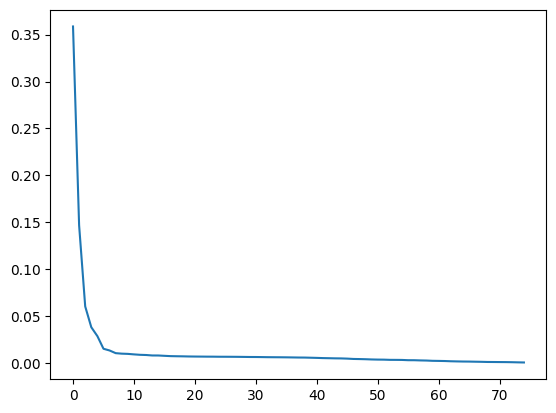

In [12]:
# apply PCA to the Fourier Data in dB
pca = PCA()
pca.fit(fx_train_magsdb)
X_train_pca = pca.transform(fx_train_magsdb)
X_val_pca = pca.transform(fx_val_magsdb)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

[0.65355762 0.80352238 0.87595167 0.9154574  0.94702503 0.96483238
 0.97478927 0.98081781 0.98469938 0.98807953 0.99016789 0.99170771
 0.99300511 0.99390535 0.99479048 0.99540649 0.99595542 0.99642048
 0.99681276 0.99718005]


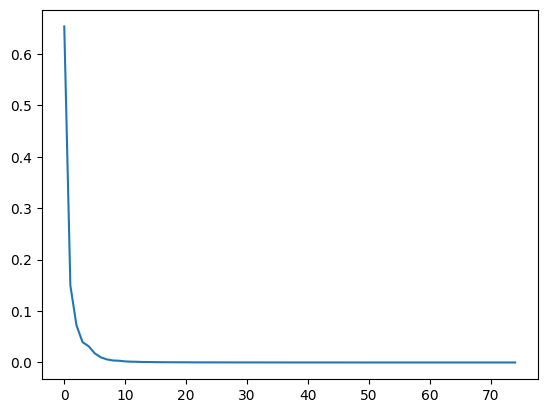

In [13]:
# apply PCA to the Fourier Data (non dB)
pca = PCA()
pca.fit(fx_train_mags)
X_train_pca = pca.transform(fx_train_mags)
X_val_pca = pca.transform(fx_val_mags)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

[0.65355762 0.80352238 0.87595167 0.9154574  0.94702503 0.96483238
 0.97478927 0.98081781 0.98469938 0.98807953 0.99016789 0.99170771
 0.99300511 0.99390535 0.99479048 0.99540649 0.99595542 0.99642048
 0.99681276 0.99718005]


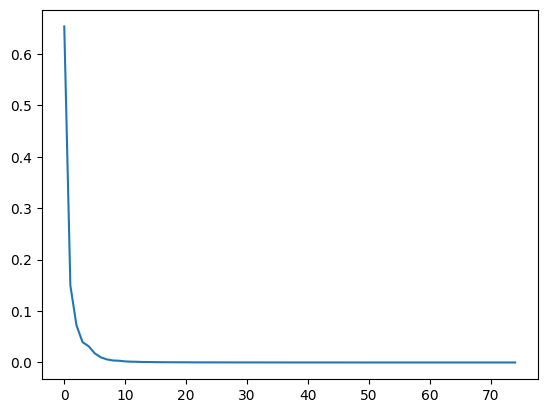

In [14]:
# apply PCA to the Fourier Data (non dB)
pca = PCA()
pca.fit(fx_train_mags)
X_train_pca = pca.transform(fx_train_mags)
X_val_pca = pca.transform(fx_val_mags)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

## Model Refinement (FFT)

In [15]:
len(fx_train_mags)

65670

In [16]:
clf_kn = KNeighborsClassifier(1)
clf_kn.fit(fx_train_mags, fy_train)
y_prediction_kn = clf_kn.predict(fx_val_mags)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

K Neighbours Classifier
Accuracy: 0.9756977753414645
F1 score: 0.7910643266242231
Recall score: 0.7654948025309606
Precision score: 0.849398157908204


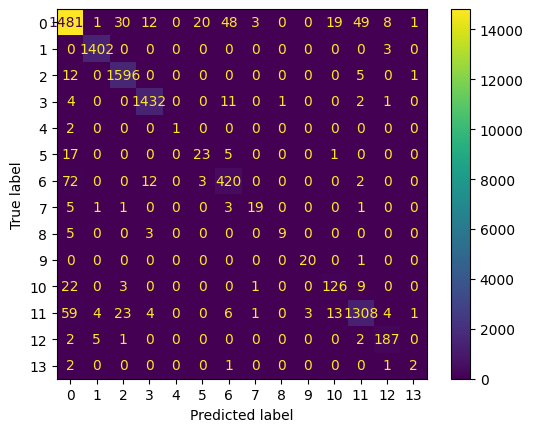

In [17]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [18]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(fx_train_mags, fy_train)
y_prediction_mlp_100 = clf_mlp_100.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9727741994426934
F1 score: 0.72315325519453
Recall score: 0.6908957201938036
Precision score: 0.7852829824178645


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


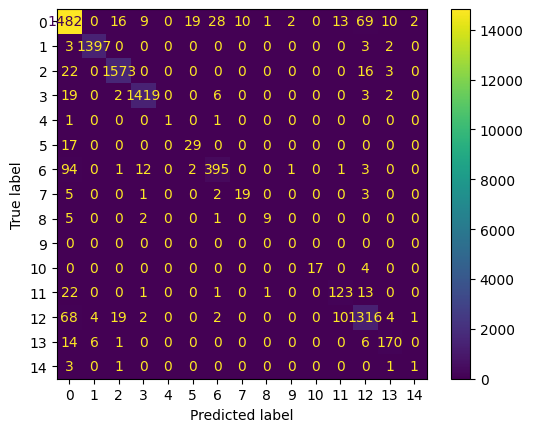

In [19]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

## Feature Design

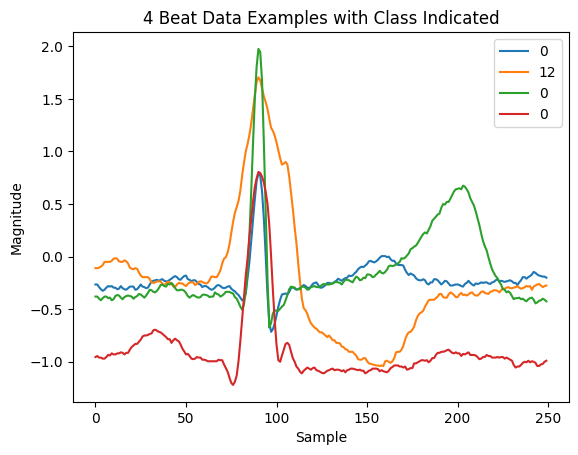

In [107]:
# plot the first few samples to visualize the data of X_train
for beat in X_train[:4]:
    plt.plot(beat)
plt.legend(y_train[:4].astype(int))
plt.title('4 Beat Data Examples with Class Indicated')
plt.ylabel('Magnitude')
plt.xlabel('Sample')
plt.savefig('./figs/sample.pdf')
plt.show()

In [21]:
def getMaxBinMean(histogram):
    (hist, edges) = histogram
    maxBin = np.argmax(hist)
    return np.mean(edges[maxBin:maxBin+2])

In [22]:
mids_train = np.array([getMaxBinMean(np.histogram(dat)) for dat in X_train])
X_train_Shifted = (X_train.transpose()-mids_train.transpose()).transpose()
mids_val = np.array([getMaxBinMean(np.histogram(dat)) for dat in X_val])
X_val_Shifted = (X_val.transpose()-mids_val.transpose()).transpose()

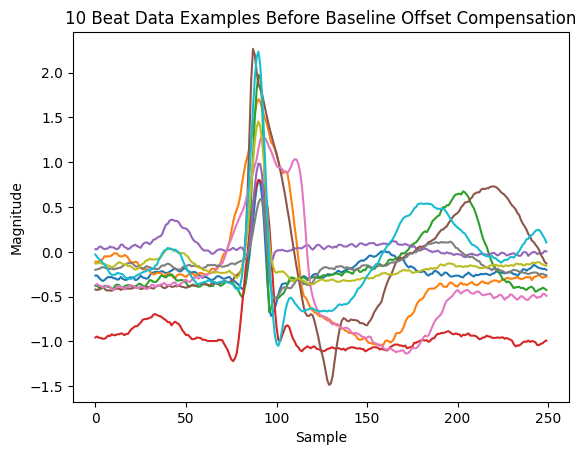

In [108]:
for beat in X_train[:10]:
    plt.plot(beat)
plt.title('10 Beat Data Examples Before Baseline Offset Compensation')
plt.ylabel('Magnitude')
plt.xlabel('Sample')
plt.savefig('./figs/preHistData.pdf')
plt.show()

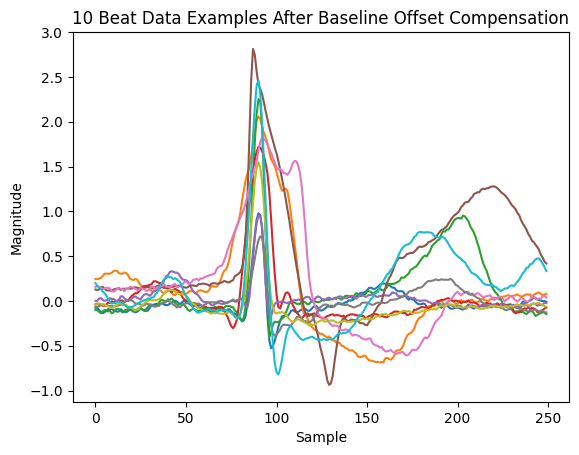

In [109]:
for beat in X_train_Shifted[:10]:
    plt.plot(beat)
plt.title('10 Beat Data Examples After Baseline Offset Compensation')
plt.ylabel('Magnitude')
plt.xlabel('Sample')
plt.savefig('./figs/postHistData.pdf')
plt.show()

In [25]:
#create a new feature that includes the derivatives in indices 250 to 498
X_train_with_der = np.concatenate((X_train, np.diff(X_train)),axis=1)
X_val_with_der = np.concatenate((X_val, np.diff(X_val)),axis=1)

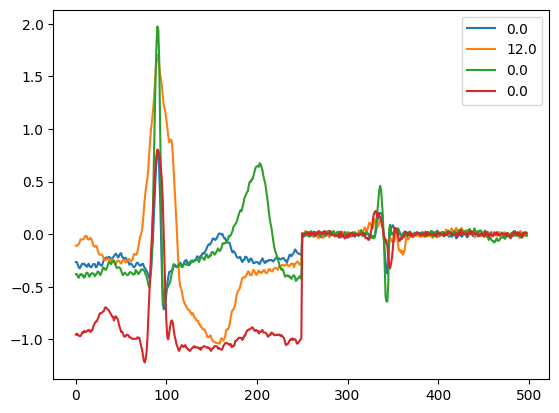

In [26]:
# plot the first few samples to visualize the data of X_train_with_der
for beat in X_train_with_der[:4]:
    plt.plot(beat)
plt.legend(y_train[:4])
plt.show()

[0.51747606 0.7102072  0.81619765 0.86865446 0.9047899  0.92423249
 0.93940956 0.95243933 0.96220591 0.96911134 0.97406081 0.97799619
 0.98164817 0.98426029 0.98658505 0.98856144 0.99000453 0.99127114
 0.99231174 0.9931061 ]


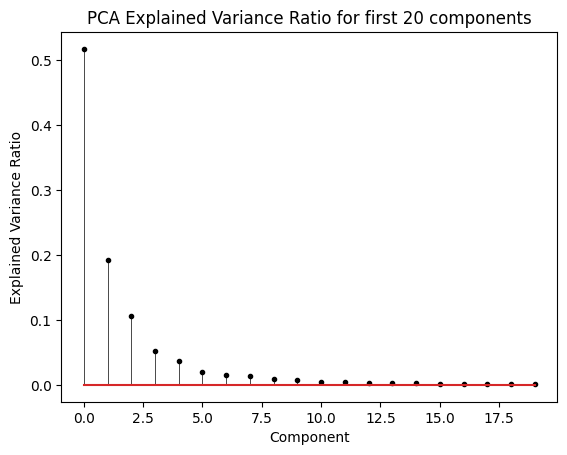

In [119]:
# apply PCA to the original data
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
markerline, stemline, baseline, = plt.stem(pca.explained_variance_ratio_[0:20], linefmt='k-', markerfmt='ko', basefmt='C3-')
plt.setp(stemline, linewidth = 0.5)
plt.setp(markerline, markersize = 3)
plt.title('PCA Explained Variance Ratio for first 20 components')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Component')
plt.savefig('./figs/pca.pdf')
plt.show()

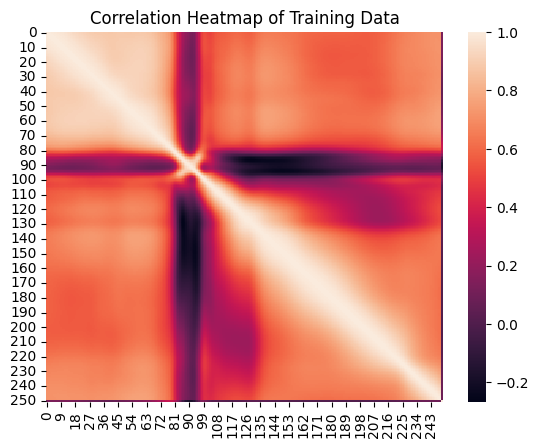

In [135]:
train_cor = df_train.corr()

ax = plt.axes()
sns.heatmap(train_cor, ax = ax, rasterized=True)
ax.set_title('Correlation Heatmap of Training Data')
plt.savefig('./figs/corr.pdf')
plt.show()

## Model Refinement

In [28]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_prediction_lr = clf_lr.predict(X_val)
print("Logistic Regression Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_lr)))
print("F1 score: " + str(f1_score(y_val, y_prediction_lr, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_lr, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_lr, average='macro')))

Logistic Regression Classifier
Accuracy: 0.884792837239048
F1 score: 0.39475818390157397
Recall score: 0.366464318190779
Precision score: 0.45092742569264554


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


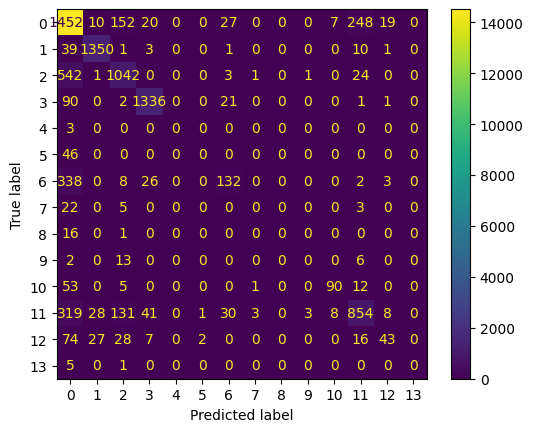

In [29]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_lr)
ConfusionMatrixDisplay(c_matrix).plot()

In [30]:
clf_kn = KNeighborsClassifier(3)
clf_kn.fit(X_train, y_train)
y_prediction_kn = clf_kn.predict(X_val)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

K Neighbours Classifier
Accuracy: 0.9801288200630396
F1 score: 0.7100244643034197
Recall score: 0.6738495998324711
Precision score: 0.8017609243151551


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


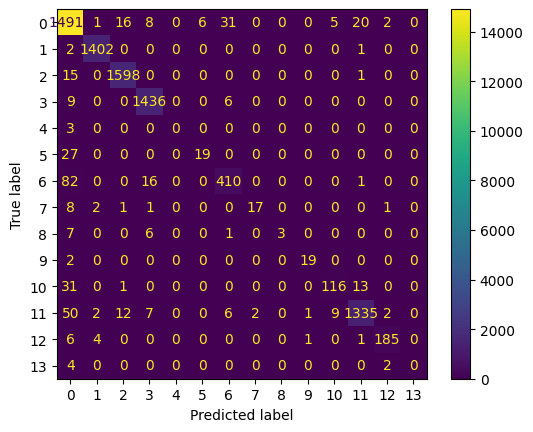

In [31]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [32]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(X_train, y_train)
y_prediction_mlp_100 = clf_mlp_100.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9830523959618108
F1 score: 0.7711761734690866
Recall score: 0.744673092234271
Precision score: 0.8097815926064224


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


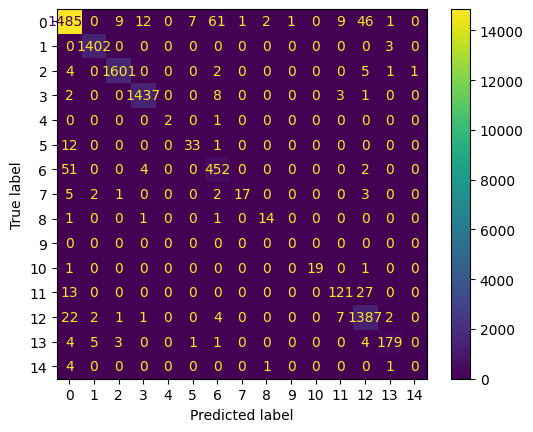

In [33]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [34]:
clf_mlp_50_50_50 = MLPClassifier(hidden_layer_sizes=(50,50,50))
clf_mlp_50_50_50.fit(X_train, y_train)
y_prediction_mlp_50_50_50 = clf_mlp_50_50_50.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_50_50_50)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_50_50_50, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_50_50_50, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_50_50_50, average='macro')))

MLP Classifier
Accuracy: 0.9838289708099219
F1 score: 0.675027635552065
Recall score: 0.6506293632436594
Precision score: 0.7222670037461926


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


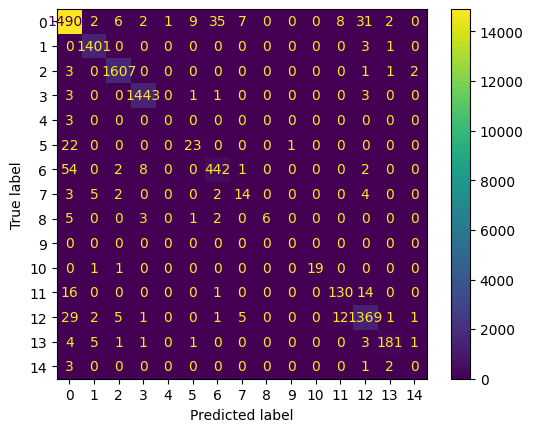

In [35]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_mlp_50_50_50)
ConfusionMatrixDisplay(c_matrix).plot()

In [36]:
clf_mlp_100_100_100_100 = MLPClassifier(hidden_layer_sizes=(100,100,100,100))
clf_mlp_100_100_100_100.fit(X_train, y_train)
y_prediction_100_100_100_100 = clf_mlp_100_100_100_100.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_100_100_100_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_100_100_100_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_100_100_100_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_100_100_100_100, average='macro')))

MLP Classifier
Accuracy: 0.9861130144808369
F1 score: 0.7734121288061224
Recall score: 0.73976410161337
Precision score: 0.8323589492354554


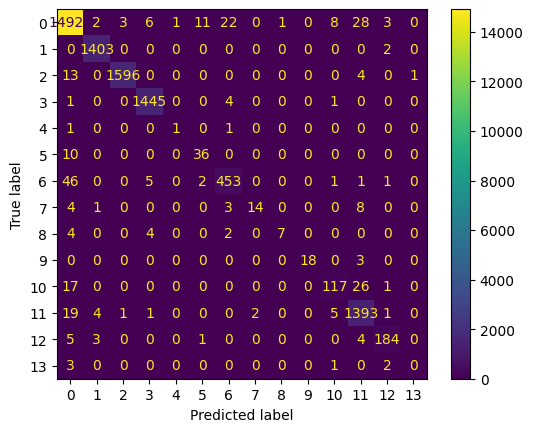

In [37]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_100_100_100_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [38]:
clf_mlp_100_pca = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100_pca.fit(X_train_pca, y_train)
y_prediction_mlp_100_pca = clf_mlp_100_pca.predict(X_val_pca)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_pca)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_pca, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_pca, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_pca, average='macro')))

MLP Classifier
Accuracy: 0.9821387784934448
F1 score: 0.8087750198853411
Recall score: 0.7839324796452986
Precision score: 0.8410072295992724


In [39]:
clf_mlp_100_der = MLPClassifier(hidden_layer_sizes=(100,100,100,100))
clf_mlp_100_der.fit(X_train_with_der, y_train)
y_prediction_mlp_100_der = clf_mlp_100_der.predict(X_val_with_der)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_der)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_der, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_der, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_der, average='macro')))

MLP Classifier
Accuracy: 0.9862957379745101
F1 score: 0.8003884867272898
Recall score: 0.7697336088233574
Precision score: 0.8540610144483799


In [40]:
clf_mlp_5s_der = MLPClassifier(hidden_layer_sizes=(100,30,30,30,30))
clf_mlp_5s_der.fit(X_train_with_der, y_train)
y_prediction_mlp_5s_der = clf_mlp_5s_der.predict(X_val_with_der)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_5s_der)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_5s_der, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_5s_der, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_5s_der, average='macro')))

MLP Classifier
Accuracy: 0.985519163126399
F1 score: 0.7411594084125915
Recall score: 0.6974213414824725
Precision score: 0.8136963050648519


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
clf_mlp_100_shifted = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100_shifted.fit(X_train_Shifted, y_train)
y_prediction_mlp_100_shifted = clf_mlp_100_shifted.predict(X_val_Shifted)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_shifted)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_shifted, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_shifted, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_shifted, average='macro')))

MLP Classifier
Accuracy: 0.9836462473162487
F1 score: 0.8086173783086197
Recall score: 0.7907468411720898
Precision score: 0.8358761692504774


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
clf_kn_shifted = KNeighborsClassifier(1)
clf_kn_shifted.fit(X_train_Shifted, y_train)
y_prediction_kn_shifted = clf_kn_shifted.predict(X_val_Shifted)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn_shifted)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn_shifted, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn_shifted, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn_shifted, average='macro')))

K Neighbours Classifier
Accuracy: 0.9834178429491572
F1 score: 0.7528601835961147
Recall score: 0.7342790753623228
Precision score: 0.7826657057268319


In [44]:
import xgboost as xgb

In [50]:
clf_xgb = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=10)
clf_xgb.fit(X_train_Shifted, y_train, eval_set=[(X_val_Shifted, y_val)])
y_prediction_xgb = clf_xgb.predict(X_val_Shifted)
print("XGB Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_xgb)))
print("F1 score: " + str(f1_score(y_val, y_prediction_xgb, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_xgb, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_xgb, average='macro')))

[0]	validation_0-mlogloss:1.08027
[1]	validation_0-mlogloss:0.78994
[2]	validation_0-mlogloss:0.61208
[3]	validation_0-mlogloss:0.48543
[4]	validation_0-mlogloss:0.39338
[5]	validation_0-mlogloss:0.32680
[6]	validation_0-mlogloss:0.27424
[7]	validation_0-mlogloss:0.23419
[8]	validation_0-mlogloss:0.20359
[9]	validation_0-mlogloss:0.17986
[10]	validation_0-mlogloss:0.16077
[11]	validation_0-mlogloss:0.14566
[12]	validation_0-mlogloss:0.13338
[13]	validation_0-mlogloss:0.12412
[14]	validation_0-mlogloss:0.11615
[15]	validation_0-mlogloss:0.11038
[16]	validation_0-mlogloss:0.10534
[17]	validation_0-mlogloss:0.10091
[18]	validation_0-mlogloss:0.09726
[19]	validation_0-mlogloss:0.09430
[20]	validation_0-mlogloss:0.09181
[21]	validation_0-mlogloss:0.08920
[22]	validation_0-mlogloss:0.08738
[23]	validation_0-mlogloss:0.08571
[24]	validation_0-mlogloss:0.08411
[25]	validation_0-mlogloss:0.08276
[26]	validation_0-mlogloss:0.08167
[27]	validation_0-mlogloss:0.08073
[28]	validation_0-mlogloss:0.0

c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.callbacks import EarlyStopping

In [90]:
clf_cnn = Sequential()
clf_cnn.add(Conv1D(16, 32, activation="relu", input_shape=(250,1)))
clf_cnn.add(Dense(32, activation="relu"))
clf_cnn.add(MaxPooling1D())
clf_cnn.add(Flatten())
clf_cnn.add(Dense(32, activation = 'softmax'))
clf_cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
clf_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 219, 16)           528       
                                                                 
 dense_22 (Dense)            (None, 219, 32)           544       
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 109, 32)           0         
 ng1D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 3488)              0         
                                                                 
 dense_23 (Dense)            (None, 32)                111648    
                                                                 
Total params: 112720 (440.31 KB)
Trainable params: 112720 (440.31 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [91]:
clf_cnn.fit(X_train_Shifted, y_train.astype(int), batch_size=16, epochs=100, verbose='auto', validation_data=(X_val_Shifted, y_val), callbacks=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, min_delta=0.002))
y_prediction_cnn = clf_cnn.predict(X_val_Shifted).argmax(axis=-1)
print("CNN Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_cnn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_cnn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_cnn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_cnn, average='macro')))

Epoch 1/100
4105/4105 [==============================] - 26s 6ms/step - loss: 0.2324 - accuracy: 0.9435 - val_loss: 0.1323 - val_accuracy: 0.9703
Epoch 2/100
4105/4105 [==============================] - 26s 6ms/step - loss: 0.1143 - accuracy: 0.9716 - val_loss: 0.1044 - val_accuracy: 0.9755
Epoch 3/100
4105/4105 [==============================] - 25s 6ms/step - loss: 0.0850 - accuracy: 0.9786 - val_loss: 0.0808 - val_accuracy: 0.9818
Epoch 4/100
4105/4105 [==============================] - 30s 7ms/step - loss: 0.0707 - accuracy: 0.9822 - val_loss: 0.0947 - val_accuracy: 0.9794
Epoch 5/100
4105/4105 [==============================] - 37s 9ms/step - loss: 0.0609 - accuracy: 0.9841 - val_loss: 0.0791 - val_accuracy: 0.9841
Epoch 6/100
4105/4105 [==============================] - 35s 9ms/step - loss: 0.0555 - accuracy: 0.9854 - val_loss: 0.0730 - val_accuracy: 0.9843
Epoch 7/100
4105/4105 [==============================] - 39s 9ms/step - loss: 0.0491 - accuracy: 0.9867 - val_loss: 0.0726 -

In [96]:
clf_cnn_2 = Sequential()
clf_cnn_2.add(Conv1D(64, 32, activation="relu", input_shape=(250,1)))
clf_cnn_2.add(Dense(100, activation="relu"))
clf_cnn_2.add(MaxPooling1D())
clf_cnn_2.add(Conv1D(16, 32, activation="relu", input_shape=(250,1)))
clf_cnn_2.add(Dense(64, activation="relu"))
clf_cnn_2.add(Flatten())
clf_cnn_2.add(Dense(32, activation = 'softmax'))
clf_cnn_2.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
clf_cnn_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 219, 64)           2112      
                                                                 
 dense_27 (Dense)            (None, 219, 100)          6500      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 109, 100)          0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 78, 16)            51216     
                                                                 
 dense_28 (Dense)            (None, 78, 64)            1088      
                                                                 
 flatten_12 (Flatten)        (None, 4992)              0         
                                                     

In [101]:
clf_cnn_2.fit(X_train_Shifted, y_train.astype(int), batch_size=32, epochs=100, verbose='auto', validation_data=(X_val_Shifted, y_val), callbacks=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, min_delta=0.002))
y_prediction_cnn_2 = clf_cnn_2.predict(X_val_Shifted).argmax(axis=-1)
print("CNN Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_cnn_2)))
print("F1 score: " + str(f1_score(y_val, y_prediction_cnn_2, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_cnn_2, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_cnn_2, average='macro')))

Epoch 1/100
2053/2053 [==============================] - 56s 27ms/step - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.1262 - val_accuracy: 0.9857
Epoch 2/100
2053/2053 [==============================] - 53s 26ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.1371 - val_accuracy: 0.9843
Epoch 3/100
2053/2053 [==============================] - 53s 26ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.1554 - val_accuracy: 0.9853
Epoch 4/100
2053/2053 [==============================] - 54s 26ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.1280 - val_accuracy: 0.9860
Epoch 5/100
2053/2053 [==============================] - 52s 25ms/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 0.1202 - val_accuracy: 0.9862
Epoch 6/100
2053/2053 [==============================] - 61s 30ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.1376 - val_accuracy: 0.9852
Epoch 7/100
2053/2053 [==============================] - 54s 26ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0

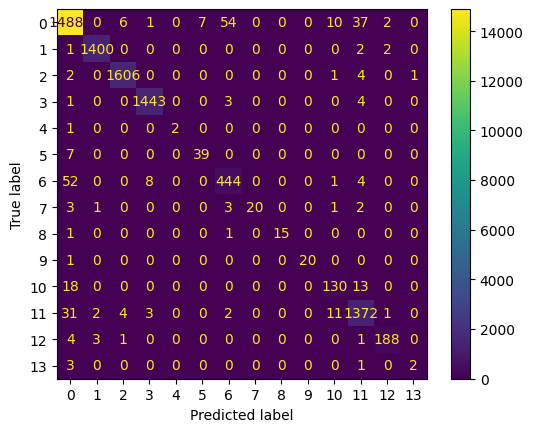

In [102]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_cnn_2)
ConfusionMatrixDisplay(c_matrix).plot()

In [103]:
clf_cnn_2.save("clf_cnn_2.keras")

In [112]:
testa = np.array([[1,2,3],[4,5,6],[7,8,9]])
row = [1,0,1]

False